In [22]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import tree
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import TruncatedSVD
import pickle

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results.p')

In [2]:
df.columns

Index(['source_dataset', 'target_dataset', 'source_device_id',
       'target_device_id', 'source_device', 'target_device',
       'source_device_name', 'target_device_name', 'source_device_type',
       'target_device_type', 'source_room', 'target_room', 'source_placement',
       'target_placement', 'type_of_transfer', 'classifier', 'label',
       'samples', 'features', 'features_name', 'accuracy', 'recall',
       'specificity', 'precision', 'f1', 'specificity_1', 'specificity_2',
       'specificity_3', 'specificity_4', 'specificity_5', 'specificity_6',
       'accuracy_wt', 'recall_wt', 'specificity_wt', 'precision_wt', 'f1_wt',
       'accuracy_change', 'recall_change', 'specificity_change',
       'precision_change', 'f1_change', 'f1_change_percent',
       'accuracy_target_wt', 'recall_target_wt', 'specificity_target_wt',
       'precision_target_wt', 'f1_target_wt'],
      dtype='object')

In [3]:
print(len(df))

# for within device transfer, only use Mites
df = df.loc[((df.source_device_type == 'Mite') & (df.target_device_type == 'Mite') | (df.source_device_type != df.target_device_type))]

# dont consider across devices transfer outside of the same place
df = df.loc[df.type_of_transfer.isin([
#     'No transfer',
    'Same device type in different place',
    'Different device in same place',
#     'Different device in different place',
    'Same device across spaces',
    'Same device type across spaces',
#     'Different device across spaces',
    'Same device in different place',
    'Same device type in same place',
    'Same device in same place'
])]

print(len(df))

62397
57312


In [25]:
def to_recall_bin(acc):
    bins = [
        [0.0, 0.75],
        [0.75, 0.85],
        [0.85, 0.95],
        [0.95, 1.0]
    ]
    return [i for i, b in enumerate(bins) if b[0] <= acc and b[1] >= acc][0]


df['recall_bin'] = [to_recall_bin(a) for a in df['recall']]

In [26]:
accuracies = {}

# filtered = df.loc[df.accuracy_negative >= 0.95]
filtered = df
filtered = filtered.loc[filtered.type_of_transfer != 'No transfer']
# filtered = filtered.loc[filtered.type_of_transfer != 'Across spaces']

x_columns = [
    'features',
    'classifier',
    'label',
    'samples',
    'type_of_transfer',
    'source_device_type',
    'target_device_type',
    'f1_wt',
    'specificity_2'
]

def to_x_and_y(filtered, columns=x_columns):

    X = filtered[columns]

    y = filtered['recall_bin']

    X = [dict(r.iteritems()) for _, r in X.iterrows()]
    y = y.values

    return X, y


X, y = to_x_and_y(filtered)

ppl = Pipeline([
    ('vect', DictVectorizer()),
    ('impute', Imputer()),
    ('clf', RandomForestClassifier())
])

# ppl.fit(X_train, y_train)
# predicted = ppl.predict(X_test)

predicted = cross_val_predict(ppl, X, y,
                              cv=StratifiedKFold(n_splits=5, shuffle=True))

accuracy = accuracy_score(y, predicted)
print(accuracy)

0.937437769665


In [28]:
ppl.fit(X, y)

Pipeline(steps=[('vect', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [17]:
DictVectorizer().fit_transform(X).shape

(54234, 41)

In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score

_actual = y > 0
_predicted = predicted > 0

print('Precision', np.round(precision_score(_actual, _predicted, pos_label=True, average='binary'), 2))
print('Recall', np.round(recall_score(_actual, _predicted, pos_label=True, average='binary'), 2))
print('F1', np.round(f1_score(_actual, _predicted, pos_label=True, average='binary'), 2))

mask_negative = y == False
print('Specificity', np.round(accuracy_score(_actual[mask_negative], _predicted[mask_negative]), 2))
print('Accuracy', np.round(accuracy_score(_actual, _predicted), 2))

Precision 0.75
Recall 0.54
F1 0.63
Specificity 0.99
Accuracy 0.95


In [19]:
np.unique(predicted)

array([0, 1, 2, 3])

In [20]:
predictions = pd.Series(predicted)
predictions.index = filtered.index
df['predictions'] = predictions

df_tested = df.loc[df.predictions >= 0]
counts = df_tested[['recall_bin', 'predictions']].groupby(['recall_bin', 'predictions']).size()
counts = pd.DataFrame(counts)
counts.columns = ['count']
counts.pivot_table(index=['recall_bin'], columns=['predictions'], values=['count'])

count                
predictions    0.0  1.0  2.0   3.0
recall_bin                        
0            49409  249  254   237
1              751  103   87    92
2              635   97  198   230
3              504   69  188  1131

In [21]:
df_tested.to_pickle('results_with_accuracy_classified_s6.p')

In [10]:
df_tested

,source_dataset,target_dataset,source_device_id,target_device_id,source_device,target_device,source_device_name,target_device_name,source_device_type,target_device_type,...,precision_change,f1_change,f1_change_percent,accuracy_target_wt,recall_target_wt,specificity_target_wt,precision_target_wt,f1_target_wt,recall_bin,predictions
162,robotics-final,robotics-final,128.237.246.127,128.237.247.134,Mite 1,Mite 4,Mite 1 Coffee,Mite 4 Sink,Mite,Mite,...,-0.448785,-0.320191,66.892937,0.982314,0.971710,0.983957,0.906039,0.937693,1,1.0
163,robotics-final,robotics-final,128.237.246.127,128.237.247.134,Mite 1,Mite 4,Mite 1 Coffee,Mite 4 Sink,Mite,Mite,...,-0.743516,-0.844182,6.328584,0.797770,0.539994,0.839893,0.355971,0.428683,0,0.0
164,robotics-final,robotics-final,128.237.246.127,128.237.247.134,Mite 1,Mite 4,Mite 1 Coffee,Mite 4 Sink,Mite,Mite,...,-0.457233,-0.478558,11.456435,0.827374,0.405515,0.898069,0.401640,0.403485,0,0.0
165,robotics-final,robotics-final,128.237.246.127,128.237.247.134,Mite 1,Mite 4,Mite 1 Coffee,Mite 4 Sink,Mite,Mite,...,-0.195318,-0.108398,88.865399,0.986928,0.975320,0.988810,0.934766,0.954574,1,1.0
166,robotics-final,robotics-final,128.237.246.127,128.237.247.134,Mite 1,Mite 4,Mite 1 Coffee,Mite 4 Sink,Mite,Mite,...,-0.388642,-0.261042,73.056791,0.987697,0.980577,0.988892,0.932440,0.955777,1,0.0
167,robotics-final,robotics-final,128.237.246.127,128.237.247.134,Mite 1,Mite 4,Mite 1 Coffee,Mite 4 Sink,Mite,Mite,...,-0.140101,-0.059993,33.559471,0.848520,0.004902,0.990124,0.074074,0.009195,0,0.0
168,robotics-final,robotics-final,128.237.246.127,128.237.247.134,Mite 1,Mite 4,Mite 1 Coffee,Mite 4 Sink,Mite,Mite,...,-0.248539,-0.318272,57.503048,0.975779,0.853733,0.994671,0.961298,0.904307,0,0.0
169,robotics-final,robotics-final,128.237.246.127,128.237.247.134,Mite 1,Mite 4,Mite 1 Coffee,Mite 4 Sink,Mite,Mite,...,-0.121518,-0.225946,44.005747,0.868897,0.456150,0.932983,0.516054,0.482941,0,0.0
170,robotics-final,robotics-final,128.237.246.127,128.237.247.134,Mite 1,Mite 4,Mite 1 Coffee,Mite 4 Sink,Mite,Mite,...,-0.078499,-0.028372,88.444498,0.825452,0.310277,0.900160,0.311860,0.310048,0,0.0
171,robotics-final,robotics-final,128.237.246.127,128.237.247.134,Mite 1,Mite 4,Mite 1 Coffee,Mite 4 Sink,Mite,Mite,...,-0.169263,-0.162014,75.296782,0.860823,0.704421,0.885060,0.490261,0.575905,0,0.0


In [57]:
filtered_x, filtered_y = to_x_and_y(filtered, columns=[
    'features',
    'classifier',
    'label',
    'samples',
    'type_of_transfer',
    'source_device_type',
    'target_device_type',
    'f1_wt',
    'specificity'
])

filtered_x = DictVectorizer().fit_transform(filtered_x)
filtered_x = pd.DataFrame(filtered_x.toarray())

filtered_y_s = pd.Series(filtered_y, index=filtered_x.index)
filtered_x_s = filtered_x.sample(10000)
filtered_y_s = filtered_y_s[filtered_x_s.index]

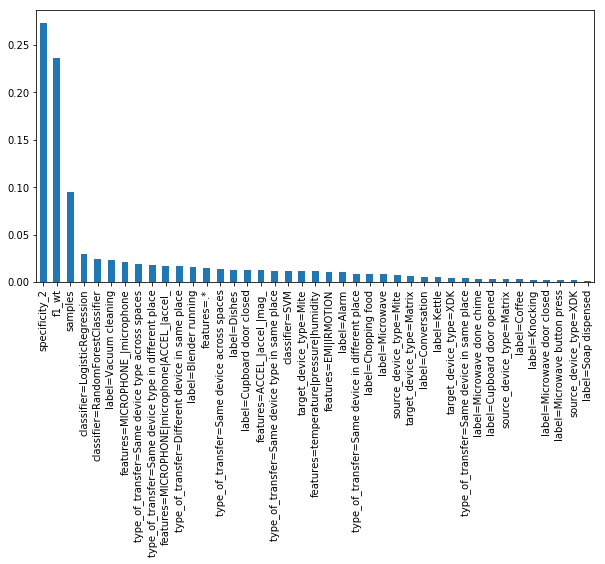

In [29]:
plt.rcParams["figure.figsize"] = (10, 5)

rf = ppl.named_steps['clf']
importances = pd.Series(rf.feature_importances_)
importances.index = ppl.named_steps['vect'].feature_names_
importances = importances.sort_values(ascending=False)
importances.plot.bar()

In [30]:
categories = {
    'f1_wt': [],
    'specificity': [],
    'samples': [],
    'features': [],
    'type_of_transfer': [],
    'device_type': [],
    'label': [],
    'classifier': []
}

for category in categories:
    for i in importances.index:
        if category in i:
            categories[category] += [importances[i]]
            
df_importances = pd.DataFrame()

for category in categories:
    df_importances = pd.concat([pd.DataFrame({category: pd.Series(categories[category])}), df_importances], axis=1)

df_importances = df_importances.rename(index=str, columns={
    'f1_wt': 'F1 score before transfer',
    'specificity': 'Specificity of target samples',
    'samples': 'Number of training samples',
    'features': 'Sensor channels used',
    'type_of_transfer': 'Type of transfer',
    'device_type': 'Types of sensor boards',
    'label': 'Activity',
    'classifier': 'Classifier'
})

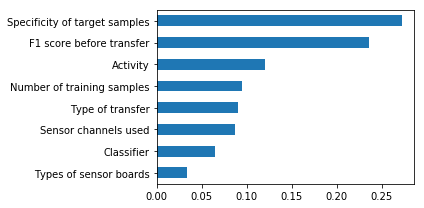

In [34]:
plt.rcParams["figure.figsize"] = (6, 3)
df_importances.sum().sort_values().plot.barh()
plt.tight_layout()

plt.savefig('../plots/metaclassifier_importances.pdf')
plt.show()